In [9]:
import boto3
import io
from sagemaker import get_execution_role

role = get_execution_role()
bucket ='sagemaker-data-energy-demand'

In [10]:
import numpy as np 
import pandas as pd 
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings('ignore')

In [11]:
CITY = 'LosAngeles'
df_file = 'dataframes/%s_reframed.csv' % CITY

df_location = 's3://{}/{}'.format(bucket, df_file)
df = pd.read_csv(df_location, index_col ='datetime')
df.tail()

,demand(t),dailycoolingdegreedays(t-1),dailyheatingdegreedays(t-1),hourlydewpointtemperature(t-1),hourlydrybulbtemperature(t-1),hourlyprecipitation(t-1),hourlyrelativehumidity(t-1),hourlyvisibility(t-1),hourlywindspeed(t-1),hourlycoolingdegrees(t-1),...,dayofweek(t),quarter(t),month(t),year(t),dayofyear(t),dayofmonth(t),weekofyear(t),isbusinessday(t),isholiday(t),daylight(t)
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-14 18:00:00+00:00,3243.0,0.0,8.0,47.0,57.0,0.0,69.0,10.0,0.0,0.0,...,1.0,1.0,1.0,2020.0,14.0,14.0,3.0,1.0,0.0,0.0
2020-01-14 19:00:00+00:00,3207.0,0.0,8.0,47.0,56.0,0.0,72.0,10.0,0.0,0.0,...,1.0,1.0,1.0,2020.0,14.0,14.0,3.0,1.0,0.0,0.0
2020-01-14 20:00:00+00:00,3066.0,0.0,8.0,47.0,55.0,0.0,74.0,10.0,0.0,0.0,...,1.0,1.0,1.0,2020.0,14.0,14.0,3.0,1.0,0.0,0.0
2020-01-14 21:00:00+00:00,2978.0,0.0,8.0,47.0,54.0,0.0,77.0,10.0,0.0,0.0,...,1.0,1.0,1.0,2020.0,14.0,14.0,3.0,1.0,0.0,0.0
2020-01-14 22:00:00+00:00,2989.0,0.0,8.0,46.0,53.0,0.0,77.0,10.0,0.0,0.0,...,1.0,1.0,1.0,2020.0,14.0,14.0,3.0,1.0,0.0,0.0


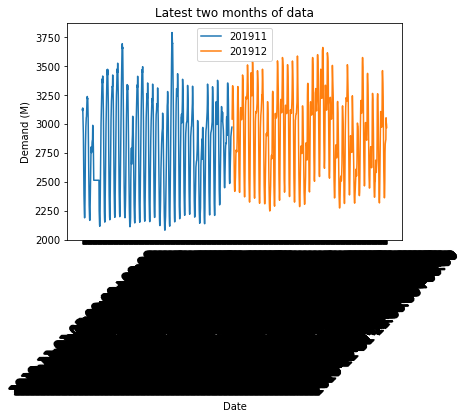

In [4]:
plt.plot(df.loc[(df['year(t)'] == 2019) & (df['month(t)'] == 11)]['demand(t)'],label='201911')
plt.plot(df.loc[(df['year(t)'] == 2019) & (df['month(t)'] == 12)]['demand(t)'],label='201912')
plt.xticks(fontsize=14, rotation=45)
plt.xlabel('Date')
plt.ylabel('Demand (M)')
plt.title('Latest two months of data')
plt.legend()
plt.show()

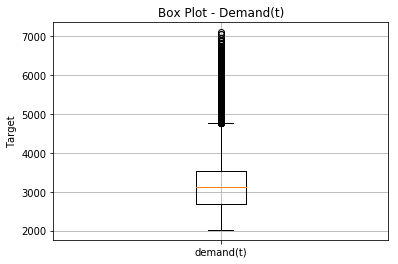

In [5]:
plt.boxplot([df['demand(t)']], labels=['demand(t)'])
plt.title('Box Plot - Demand(t)')
plt.ylabel('Target')
plt.grid(True)

In [12]:
#split_date = '2019-12-01 01:00:00+00:00'
lastrow_date = df.tail(1).index.values[0]
               
datetime_lastrow = datetime.strptime(lastrow_date[:-6], '%Y-%m-%d %H:%M:%S')
split_validation_date = datetime_lastrow - timedelta(days=365)
split_validation_date_str = str(split_validation_date)


df_train = df.loc[df.index <= split_validation_date_str].copy()
df_validation = df.loc[df.index > split_validation_date_str].copy()

print(df_train.shape)
print(df_validation.shape)

(31046, 37)
(8761, 37)


In [13]:
print((df_train.shape[0] + df_validation.shape[0]) == df.shape[0])

True


In [14]:
# save as csv file to continue in another notebook
s3_resource = boto3.resource('s3')

all_buffer = io.StringIO()
all_key = 'dataframes/%s_reframed_all.csv' % CITY
df.to_csv(all_buffer, compression=None)

train_buffer = io.StringIO()
train_key = 'dataframes/%s_reframed_train.csv' % CITY
df_train.to_csv(train_buffer, compression=None)

validation_buffer = io.StringIO()
validation_key = 'dataframes/%s_reframed_validation.csv' % CITY
df_validation.to_csv(validation_buffer, compression=None)


s3_resource.Object(bucket, all_key).put(Body=all_buffer.getvalue())
s3_resource.Object(bucket, train_key).put(Body=train_buffer.getvalue())
s3_resource.Object(bucket, validation_key).put(Body=validation_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '6ABC0378CE415C2F',
  'HostId': 'U2VMxoclHyw9RE0StnvGgPzMtZOT+u3C8f5dKgpXUmzGEVwY1r5xyqNRymni8FPJOQQj3nauyrQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'U2VMxoclHyw9RE0StnvGgPzMtZOT+u3C8f5dKgpXUmzGEVwY1r5xyqNRymni8FPJOQQj3nauyrQ=',
   'x-amz-request-id': '6ABC0378CE415C2F',
   'date': 'Fri, 17 Jan 2020 18:03:41 GMT',
   'etag': '"4c29d1afb9974acfa937085523fe7632"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"4c29d1afb9974acfa937085523fe7632"'}